# Information we have

If distance == 1 (exoprotease), this is more likely.

We have a probability distribution over cut-sites at p1.

# Loss function

Because probabilities: $\sum|w_i| = $ number of nodes

We want to focus weight on a small set of nodes. This could then be number of nonzero weights: $N_{w>0}$.

Possible loss function with KL and L1:

$Loss(w)$ = $D_{KL}(w)$ + $\lambda*N_{w>0}$

$D_{KL}(w) = \sum q(x | w) log(\frac{q(x | w)}{p(x)})$

Loss function with difference and L1:

$Loss = \sum_i|q(x_i)-q(\hat{x_i})| + \lambda*N_{w>0}$


# Weight updating

We want to update with respect to the gradient of each weight. 

$source * weight$ is how much the weight contributes to the target.


In [37]:
import networkx as nx
import numpy as np


P = {
    "ABCD": 200,
    "ABC": 200,
    "BCD": 50,
    "BC": 50,
    "C": 100,
    "AB": 200,
    "B": 100,
    "A": 50,
}
keys = list(P.keys())
values = list(P.values())

G = nx.DiGraph()
G.add_nodes_from([(k, {"layer": len(k)}) for k in keys])
for key1 in keys:
    for key2 in keys:
        if key1 == key2:
            G.add_edge(key2, key1, weight=np.random.uniform(0.5, 1))
        elif key2.startswith(key1) or key2.endswith(key1):  # key 1 = ABC, key 2 = ABCD
            G.add_edge(key2, key1, weight=np.random.uniform(0, 1))

for node in G.nodes():
    out_edges = G.out_edges(node, data=True)

    total_out = sum([data["weight"] for s, t, data in out_edges])
    for key, target, data in out_edges:
        nx.set_edge_attributes(
            G, {(key, target): {"weight": data["weight"] / total_out}}
        )

In [38]:
def generate_guess(G: nx.DiGraph, keys):
    """
    Outputs a tuple of the distribution for the longest node and a matrix
    """
    longest_key = sorted(keys, key=len)[-1]
    p_generated = {}
    terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 1]

    for node in terminal_nodes:  # one hot terminal nodes
        oh_node = create_one_hot(keys, node)
        p_generated[node] = oh_node

    out_edges = {
        source: [target for _, target in G.out_edges(source) if source != target]
        for source in G.nodes()
    }

    while len(p_generated.keys()) < len(keys):
        solvables = get_solvable(out_edges, p_generated)
        for solvable in solvables:
            p_generated[solvable] = np.zeros(len(keys))
            for source, target in G.out_edges(solvable):
                if source == target:
                    p_target = create_one_hot(keys, source)
                else:
                    p_target = p_generated[target]
                w_source_target = G[source][target]["weight"]
                p_generated[source] += w_source_target * p_target
    guess = {keys[i] : p_generated[longest_key][i] for i in range(len(keys))}
    return guess, pd.DataFrame(p_generated, index=keys)


import pandas as pd


def create_one_hot(keys, key):
    one_hot = np.zeros(len(keys))
    one_hot[keys.index(key)] = 1
    return one_hot


def get_solvable(out_edges, p_generated):
    solvable = []
    for source, targets in out_edges.items():
        if (
            set(targets).issubset(set((p_generated.keys())))
            and source not in p_generated.keys()
        ):
            solvable.append(source)
    return solvable

guess, df = generate_guess(G, keys)
guess

{'ABCD': 0.22611671648229992,
 'ABC': 0.07028770909065386,
 'BCD': 0.009926304378120771,
 'BC': 0.013702349107551883,
 'C': 0.044919960336891974,
 'AB': 0.18212188778765828,
 'B': 0.02907890618778704,
 'A': 0.4238461666290363}

$dL / dp = ln(p/q) + 1$

$dp / dw = P ( $ arriving at source $ ) * P( $ target $ )$

$dL / dw = dL / dp * dp / dw$

In [39]:
def compute_dp_dw(G, keys, guess):
    longest_key = sorted(keys, key=len)[-1]
    prob_traversed = {key: 0 for key in keys}

    prob_traversed[longest_key] = 1
    for sequence, n in prob_traversed.items():
        out_edges = [
            (source, target, data)
            for source, target, data in G.out_edges(sequence, data=True)
            if source != target
        ]
        weights = np.array([weight["weight"] for _, _, weight in out_edges])
        edges_to = [edge_to for _, edge_to, _ in out_edges]
        for w, e in zip(weights, edges_to):
            prob_traversed[e] += w * n


    dp_dw = {}

    for key in keys:
        out_edges = G.out_edges(key)
        for source, target in out_edges:
            dp_dw[(source, target)] = prob_traversed[source] * guess[target]

    return dp_dw

from disassembly.estimate_weights import KL_gradient, KL
def compute_dL_dp(q,p):
    return KL_gradient(q,p)

def compute_dL_dw(dL_dp, dp_dw):
    for edge, val in dp_dw.items():
        dp_dw[edge] = val*dL_dp
    return dp_dw

dp_dw = compute_dp_dw(G, keys, guess)
dL_dp = compute_dL_dp(guess.values(), P.values())

compute_dL_dw(dL_dp, dp_dw)

{('ABCD', 'ABCD'): 0.8510218386204425,
 ('ABCD', 'ABC'): 0.2645376085117058,
 ('ABCD', 'BCD'): 0.03735903268892437,
 ('ABCD', 'AB'): 0.6854411571566015,
 ('ABCD', 'A'): 1.5952042362383416,
 ('ABC', 'ABC'): 0.0577896349429695,
 ('ABC', 'BC'): 0.011265892188423023,
 ('ABC', 'C'): 0.03693260376680613,
 ('ABC', 'AB'): 0.14973823370454253,
 ('ABC', 'A'): 0.3484807736424856,
 ('BCD', 'BCD'): 0.0008668730360888347,
 ('BCD', 'BC'): 0.0011966383983342441,
 ('BCD', 'B'): 0.0025394868757713466,
 ('BC', 'BC'): 0.0026398190592156205,
 ('BC', 'C'): 0.008654031984280924,
 ('BC', 'B'): 0.0056021817991307975,
 ('C', 'C'): 0.007594282752505478,
 ('AB', 'AB'): 0.30392587185939435,
 ('AB', 'B'): 0.0485270168412982,
 ('AB', 'A'): 0.7073164971647163,
 ('B', 'B'): 0.003182468893312917,
 ('A', 'A'): 0.6761212005200207}

In [40]:
def update_weights(G, grad, lr):
    for source, target in G.edges():
        old_weight = G[source][target]["weight"]
        new_weight = old_weight - lr*grad[(source, target)]
        nx.set_edge_attributes(
                G, {(source, target): {"weight": new_weight}}
            )
    # normalizw to probabilities
    for key in G.nodes():   
        out_edges = G.out_edges(key, data=True)
        total_out = sum([data["weight"] for _, _, data in out_edges])
        for key, target, data in out_edges:
            nx.set_edge_attributes(
                G, {(key, target): {"weight": data["weight"] / total_out}}
            )
    return G

In [41]:
# the loop

# 1. generate_guess
# 2. compute loss (KL)
# 3. compute gradient
#       a. compute dL_dp
    #   b. compute dp_dw

guess, df = generate_guess(G, keys)
loss = KL(guess.values(), P.values())

dp_dw = compute_dp_dw(G, keys, guess)
dL_dp = compute_dL_dp(guess.values(), P.values())
grad = compute_dL_dw(dL_dp, dp_dw)
lr = 0.001
generated = {}
kls = []
for i in range(1000):
    guess, df = generate_guess(G, keys)
    generated[i] = guess
    kl = KL(guess.values(), P.values()) 
    dp_dw = compute_dp_dw(G, keys, guess)
    dL_dp = compute_dL_dp(guess.values(), P.values())
    if dL_dp == np.nan:
        print(guess)
    grad = compute_dL_dw(dL_dp, dp_dw)
    G = update_weights(G, grad, lr)
    kls.append(kl)

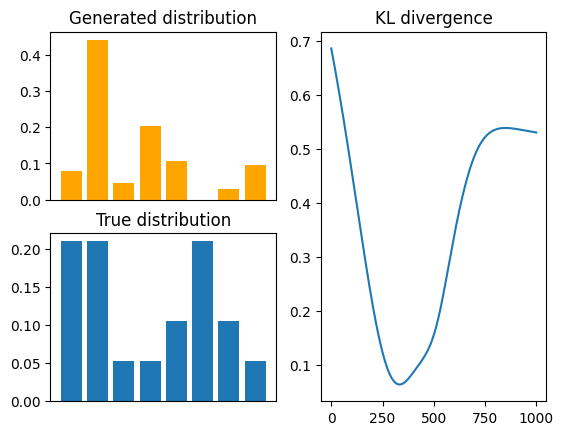

In [42]:
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 5), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 5

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()